# Exploratory Analysis with Irregular Boundary
In this file, the actual boundary of Whitelee Windfarm will be utilised.

In [1]:
# import useful libraries

import numpy as np
import netCDF4
import matplotlib.pyplot as plt
import folium.features
import folium.raster_layers
import folium
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

from Land.main import land, feasibility
from CRS.crs_init import CRSConvertor
from Optimiser.config_ss import *
from Optimiser.main import *

# 1. Current Layout
First, we display the original wind farm layout here.

In [2]:
# prerequisites
# read wind turbine locations
turbine_loc = np.loadtxt('Aborted/case/Turbines_At_Whitelee_Wind_Farm.csv', delimiter=',', encoding='utf-8', usecols=[1, 2])

image_file = image_file = 'https://github.com/ShitianZhang22/Wind-Farm-Layout-Optimisation/blob/main/icon/turbine.png?raw=true'

_wind_data = np.array([[2.3046875, 0.0390625],
                       [3.1015625, 0.125    ],
                       [2.8203125, 0.09375  ],
                       [2.5      , 0.078125 ],
                       [3.9375   , 0.140625 ],
                       [4.2890625, 0.2265625],
                       [3.9296875, 0.2265625],
                       [2.9140625, 0.078125 ]])

In [3]:
# Create a folium map centered around the site
m = folium.Map(location=[55.6741, -4.2713], zoom_start=12, tiles='CartoDB.PositronNoLabels')

# Visualize the boundary on a folium map
boundary_file = 'Land/data/WhiteleeBoundary.geojson'
boundary = gpd.read_file(boundary_file)

# Calculate the bounding box
bounds = boundary.total_bounds  # [minx, miny, maxx, maxy]
bounding_box = [[bounds[1], bounds[0]], [bounds[3], bounds[2]]]

# Add the bounding box to the map. This part is currently commented out but may be useful in the future.
# folium.Rectangle(
#     bounds=bounding_box,
#     color='blue',
#     weight=2,
#     fill=False
# ).add_to(m)

# Remove the filling display of the geojson file but keep the boundary
folium.GeoJson(
    boundary,
    style_function=lambda x: {
        'fillOpacity': 0,  # Make the fill transparent
        'color': 'black',  # Keep the boundary visible
        'weight': 2
    }
).add_to(m)

# Add the current wind turbines to the map
for i in range(turbine_loc.shape[0]):  # add turbine locations
    folium.Marker(
        location=[turbine_loc[i, 0], turbine_loc[i, 1]],
        icon=folium.CustomIcon(icon_image=image_file, icon_size=(20, 20), icon_anchor=(10, 20)),
        color='red'
    ).add_to(m)

# Display land cover type within the geojson boundary
land_cover_file = 'Land/raw/C3S-LC-L4-LCCS-Map-300m-P1Y-2022-v2.1.1.nc'
with netCDF4.Dataset(land_cover_file, 'r') as file:
    land_class = file.variables['lccs_class']
    lat = file.variables['lat'][:]
    lon = file.variables['lon'][:]

    # Filter points within the bounding box
    y_range = np.argwhere((lat < bounds[3]) & (lat > bounds[1])).flatten()
    x_range = np.argwhere((lon < bounds[2]) & (lon > bounds[0])).flatten()

    # Extract the land cover data within the bounding box
    land_cover = land_class[0, y_range.min():y_range.max()+1, x_range.min():x_range.max()+1].data

    # Create an RGBA image for the land cover data
    rgba_img = np.zeros((len(y_range), len(x_range), 4), dtype=np.uint8)
    colourmap = {
        70: [0, 60, 0, 128],
        100: [140, 160, 0, 128],
        110: [190, 150, 0, 128],
        130: [255, 180, 50, 128],
        180: [0, 220, 130, 128],
        210: [0, 70, 200, 128],
    }

    for key, color in colourmap.items():
        rgba_img[land_cover == key] = color

    # Assign transparent color to data outside the geojson boundary
    for i, lat_val in enumerate(lat[y_range]):
        for j, lon_val in enumerate(lon[x_range]):
            point = Point(lon_val, lat_val)
            if not boundary.union_all().contains(point):
                rgba_img[i, j, 3] = 0  # Set alpha to 0 for transparency

    # Add the RGBA image to the map
    folium.raster_layers.ImageOverlay(
        image=rgba_img,
        bounds=bounding_box,
        origin='upper',
        opacity=1
    ).add_to(m)

# Add a legend to the map
legend_html = '''
    <div style="position: fixed; 
                bottom: 50px; right: 50px; width: auto; height: auto; 
                background-color: rgba(255, 255, 255, 0.8); border: 2px solid black; z-index:9999; font-size:14px;">
        <h4 style="margin: 10px; font-weight: bold; font-size: 20px;">Legend</h4>
        <ul style="list-style: none; padding: 0; margin: 10px;">
            <li><img src="https://github.com/ShitianZhang22/Wind-Farm-Layout-Optimisation/blob/main/icon/turbine-small.png?raw=true" style="width: 15px; height: 15px; margin-right: 2px;">Wind Turbine</li>
            <li><span style="background-color: black; width: 12px; height: 3px; display: inline-block; margin-right: 5px; margin-bottom: 4px;"></span>Site Boundary</li>
            <li><span style="background-color: rgba(0, 60, 0, 0.5); width: 12px; height: 12px; display: inline-block; margin-right: 5px;"></span>Tree Cover, Needleleaved, Evergreen, Closed to Open</li>
            <li><span style="background-color: rgba(140, 160, 0, 0.5); width: 12px; height: 12px; display: inline-block; margin-right: 5px;"></span>Mosaic Tree and Shrub (>50%) / Herbaceous Cover (<50%)</li>
            <li><span style="background-color: rgba(190, 150, 0, 0.5); width: 12px; height: 12px; display: inline-block; margin-right: 5px;"></span>Mosaic Herbaceous Cover (>50%) / Tree and Shrub (<50%)</li>
            <li><span style="background-color: rgba(255, 180, 50, 0.5); width: 12px; height: 12px; display: inline-block; margin-right: 5px;"></span>Grassland</li>
            <li><span style="background-color: rgba(0, 220, 130, 0.5); width: 12px; height: 12px; display: inline-block; margin-right: 5px;"></span>Shrub or Herbaceous Cover, Flooded, Fresh/Saline/Brackish Water</li>
            <li><span style="background-color: rgba(0, 70, 200, 0.5); width: 12px; height: 12px; display: inline-block; margin-right: 5px;"></span>Water Bodies</li>
        </ul>
    </div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

# Display the map
m

# 2. Optimisation

Here we do some optimisation. This part can be skipped if the first line is not commented.

First, we need the feasible cells.

In [4]:
# Here are some prerequisites.
# this is for converting the CRS
print('Bounding box:')
print(bounds, '\n')

conv = CRSConvertor([bounds[3], bounds[0], bounds[1], bounds[2]], cell_width)
print('Grid size:')
print(conv.rows, conv.cols)

rows = conv.rows
cols = conv.cols

Bounding box:
[-4.40025458 55.63733847 -4.15341513 55.72078914] 

Grid size:
58 101


In [5]:
%%script true
# The result is at the next cell.
# First, we need to filter the cells within the real boundary from the geojson file.
within_boundary = np.zeros((conv.rows * conv.cols), dtype=bool)

for i in range(conv.grid_gcs.shape[0]):
    point = Point(conv.grid_gcs[i, 1], conv.grid_gcs[i, 0])
    if boundary.union_all().contains(point):
        within_boundary[i] = True
print('The number of cells within the boundary:', np.sum(within_boundary))

# Then, we check the feasibility of the grid cells.
feasible_ind = land('Land/data/infeasible.nc', conv.grid_gcs)
# A stupid step: convert the feasible_ind back to boolean
feasible_temp = np.zeros((conv.rows * conv.cols), dtype=bool)
for i in range(len(feasible_ind)):
    feasible_temp[feasible_ind[i]] = True
print('The number of feasible cells:', np.sum(feasible_temp))

gene_space = feasible_temp & within_boundary
print('The final feasible cells within the boundary:', np.sum(gene_space))
gene_space = np.argwhere(gene_space).T[0].tolist()
print('The feasible cells are:', gene_space)

In [6]:
## feasible cells
gene_space = [19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 221, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 350, 351, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 447, 448, 449, 450, 451, 452, 534, 535, 536, 537, 538, 539, 540, 541, 542, 547, 548, 549, 550, 551, 552, 553, 637, 638, 639, 640, 641, 642, 643, 648, 649, 650, 651, 652, 653, 654, 655, 669, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 770, 771, 772, 773, 774, 777, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 869, 870, 872, 873, 874, 875, 876, 877, 878, 879, 880, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1170, 1171, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1240, 1241, 1242, 1243, 1244, 1245, 1246, 1247, 1248, 1249, 1250, 1251, 1252, 1253, 1254, 1255, 1256, 1257, 1258, 1259, 1260, 1261, 1262, 1263, 1264, 1265, 1266, 1267, 1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280, 1281, 1282, 1283, 1341, 1342, 1343, 1344, 1345, 1346, 1347, 1348, 1349, 1350, 1351, 1352, 1353, 1354, 1355, 1356, 1357, 1358, 1359, 1360, 1361, 1362, 1363, 1364, 1365, 1366, 1367, 1368, 1369, 1372, 1373, 1374, 1375, 1376, 1377, 1378, 1379, 1380, 1381, 1382, 1383, 1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460, 1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470, 1473, 1474, 1475, 1476, 1477, 1478, 1479, 1480, 1481, 1482, 1483, 1484, 1485, 1544, 1545, 1546, 1547, 1548, 1549, 1550, 1551, 1552, 1553, 1554, 1555, 1556, 1557, 1558, 1559, 1560, 1561, 1562, 1563, 1564, 1565, 1566, 1567, 1568, 1569, 1570, 1575, 1576, 1577, 1578, 1579, 1580, 1581, 1582, 1583, 1584, 1585, 1586, 1587, 1588, 1589, 1646, 1647, 1648, 1649, 1650, 1651, 1652, 1653, 1654, 1655, 1656, 1657, 1658, 1659, 1660, 1661, 1662, 1663, 1664, 1665, 1666, 1667, 1668, 1669, 1670, 1671, 1676, 1677, 1678, 1679, 1680, 1681, 1682, 1683, 1684, 1685, 1686, 1687, 1688, 1689, 1690, 1691, 1692, 1748, 1749, 1750, 1751, 1752, 1753, 1754, 1755, 1756, 1757, 1758, 1759, 1760, 1761, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 1771, 1772, 1777, 1778, 1779, 1780, 1781, 1782, 1783, 1784, 1785, 1786, 1787, 1788, 1789, 1790, 1791, 1792, 1793, 1842, 1844, 1845, 1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859, 1860, 1861, 1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870, 1871, 1872, 1876, 1877, 1878, 1879, 1880, 1881, 1882, 1883, 1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893, 1894, 1943, 1944, 1945, 1946, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2142, 2143, 2144, 2145, 2146, 2147, 2148, 2149, 2150, 2151, 2152, 2153, 2154, 2155, 2156, 2157, 2158, 2159, 2160, 2161, 2162, 2163, 2164, 2165, 2166, 2167, 2168, 2169, 2170, 2171, 2172, 2173, 2174, 2175, 2176, 2177, 2178, 2179, 2180, 2181, 2182, 2183, 2184, 2185, 2186, 2187, 2188, 2189, 2190, 2191, 2192, 2193, 2194, 2195, 2196, 2197, 2198, 2199, 2203, 2204, 2208, 2209, 2244, 2245, 2246, 2247, 2248, 2249, 2250, 2251, 2252, 2253, 2254, 2255, 2256, 2257, 2258, 2259, 2260, 2261, 2262, 2263, 2264, 2265, 2266, 2267, 2268, 2269, 2270, 2271, 2272, 2273, 2274, 2275, 2276, 2277, 2278, 2279, 2280, 2281, 2282, 2283, 2284, 2285, 2286, 2287, 2288, 2289, 2290, 2291, 2292, 2293, 2294, 2295, 2296, 2297, 2298, 2299, 2300, 2303, 2304, 2305, 2306, 2309, 2310, 2311, 2342, 2343, 2344, 2345, 2346, 2347, 2348, 2349, 2350, 2351, 2352, 2353, 2354, 2355, 2356, 2357, 2358, 2359, 2360, 2361, 2362, 2363, 2364, 2365, 2366, 2367, 2368, 2369, 2370, 2371, 2372, 2373, 2374, 2375, 2376, 2377, 2378, 2379, 2380, 2381, 2382, 2383, 2384, 2385, 2386, 2387, 2388, 2389, 2390, 2391, 2392, 2393, 2394, 2395, 2396, 2397, 2398, 2399, 2400, 2403, 2404, 2405, 2406, 2407, 2408, 2409, 2410, 2411, 2412, 2413, 2414, 2443, 2444, 2445, 2446, 2447, 2448, 2449, 2450, 2451, 2452, 2453, 2454, 2455, 2456, 2457, 2458, 2459, 2460, 2461, 2462, 2463, 2464, 2465, 2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2504, 2505, 2506, 2507, 2508, 2509, 2510, 2511, 2512, 2513, 2514, 2515, 2516, 2517, 2520, 2521, 2543, 2544, 2545, 2546, 2547, 2548, 2549, 2550, 2551, 2552, 2553, 2554, 2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 2600, 2601, 2605, 2606, 2607, 2608, 2609, 2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2620, 2621, 2622, 2623, 2624, 2625, 2634, 2635, 2636, 2637, 2643, 2645, 2646, 2647, 2648, 2649, 2650, 2651, 2652, 2653, 2654, 2655, 2656, 2657, 2658, 2659, 2660, 2661, 2662, 2663, 2664, 2665, 2666, 2667, 2668, 2669, 2670, 2671, 2672, 2673, 2674, 2675, 2676, 2677, 2678, 2679, 2680, 2681, 2682, 2683, 2684, 2685, 2686, 2687, 2688, 2689, 2690, 2691, 2692, 2693, 2694, 2695, 2696, 2697, 2698, 2699, 2700, 2701, 2704, 2705, 2706, 2707, 2708, 2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726, 2734, 2735, 2736, 2737, 2738, 2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802, 2805, 2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825, 2826, 2827, 2829, 2830, 2831, 2832, 2833, 2834, 2835, 2836, 2837, 2838, 2839, 2840, 2845, 2846, 2847, 2848, 2849, 2850, 2851, 2852, 2853, 2854, 2855, 2856, 2857, 2858, 2859, 2860, 2861, 2862, 2863, 2864, 2865, 2866, 2867, 2868, 2869, 2870, 2871, 2872, 2873, 2874, 2875, 2876, 2877, 2878, 2879, 2880, 2881, 2882, 2883, 2884, 2885, 2886, 2887, 2888, 2889, 2890, 2891, 2892, 2893, 2894, 2895, 2896, 2897, 2898, 2899, 2900, 2901, 2902, 2903, 2904, 2906, 2907, 2908, 2909, 2910, 2911, 2912, 2913, 2914, 2915, 2916, 2917, 2918, 2919, 2920, 2921, 2922, 2923, 2924, 2925, 2926, 2927, 2928, 2930, 2931, 2932, 2933, 2934, 2935, 2936, 2937, 2938, 2939, 2940, 2941, 2942, 2946, 2947, 2948, 2949, 2950, 2951, 2952, 2953, 2954, 2955, 2956, 2957, 2958, 2959, 2960, 2961, 2962, 2963, 2964, 2965, 2966, 2967, 2968, 2969, 2970, 2971, 2972, 2973, 2974, 2975, 2976, 2977, 2978, 2979, 2980, 2981, 2982, 2983, 2984, 2985, 2986, 2987, 2988, 2989, 2990, 2991, 2992, 2993, 2994, 2995, 2996, 2997, 2998, 2999, 3000, 3001, 3002, 3003, 3004, 3005, 3006, 3007, 3008, 3009, 3010, 3011, 3012, 3013, 3014, 3015, 3016, 3017, 3018, 3019, 3020, 3021, 3022, 3023, 3024, 3025, 3026, 3027, 3028, 3029, 3032, 3033, 3034, 3035, 3036, 3037, 3038, 3039, 3040, 3041, 3042, 3043, 3044, 3045, 3046, 3047, 3048, 3049, 3050, 3051, 3052, 3053, 3054, 3055, 3056, 3057, 3058, 3059, 3060, 3061, 3062, 3063, 3064, 3065, 3066, 3067, 3068, 3069, 3070, 3071, 3072, 3073, 3074, 3075, 3076, 3077, 3078, 3079, 3080, 3081, 3082, 3083, 3084, 3085, 3086, 3087, 3088, 3089, 3090, 3091, 3092, 3093, 3094, 3095, 3096, 3097, 3098, 3099, 3100, 3101, 3102, 3103, 3104, 3105, 3106, 3107, 3108, 3109, 3110, 3111, 3112, 3113, 3114, 3115, 3116, 3117, 3118, 3119, 3120, 3121, 3122, 3123, 3124, 3125, 3126, 3127, 3128, 3129, 3139, 3140, 3141, 3142, 3143, 3144, 3145, 3146, 3147, 3148, 3149, 3150, 3151, 3152, 3153, 3154, 3155, 3156, 3157, 3158, 3159, 3160, 3161, 3162, 3163, 3164, 3165, 3166, 3167, 3168, 3169, 3170, 3171, 3172, 3173, 3174, 3175, 3176, 3177, 3178, 3179, 3180, 3181, 3182, 3183, 3184, 3185, 3186, 3187, 3188, 3189, 3190, 3191, 3192, 3193, 3194, 3195, 3196, 3197, 3198, 3199, 3200, 3201, 3202, 3203, 3204, 3205, 3206, 3207, 3208, 3209, 3210, 3211, 3212, 3213, 3214, 3215, 3216, 3217, 3218, 3219, 3220, 3221, 3222, 3223, 3224, 3225, 3226, 3228, 3229, 3230, 3240, 3241, 3242, 3243, 3244, 3245, 3246, 3247, 3248, 3249, 3250, 3251, 3252, 3253, 3254, 3255, 3256, 3257, 3258, 3259, 3260, 3261, 3262, 3263, 3264, 3265, 3266, 3267, 3268, 3269, 3270, 3271, 3272, 3273, 3274, 3275, 3276, 3277, 3278, 3279, 3280, 3281, 3282, 3283, 3284, 3285, 3286, 3287, 3288, 3289, 3290, 3291, 3292, 3293, 3294, 3295, 3296, 3297, 3298, 3299, 3300, 3301, 3302, 3303, 3304, 3305, 3306, 3307, 3308, 3309, 3310, 3311, 3312, 3313, 3314, 3315, 3316, 3317, 3318, 3319, 3320, 3321, 3322, 3323, 3324, 3325, 3326, 3341, 3342, 3343, 3344, 3345, 3346, 3347, 3348, 3349, 3350, 3351, 3352, 3353, 3354, 3355, 3356, 3357, 3358, 3359, 3360, 3361, 3362, 3363, 3364, 3365, 3366, 3367, 3368, 3369, 3370, 3371, 3372, 3373, 3374, 3375, 3376, 3377, 3378, 3379, 3380, 3381, 3382, 3383, 3384, 3385, 3386, 3387, 3388, 3389, 3390, 3391, 3392, 3393, 3394, 3395, 3396, 3397, 3398, 3399, 3400, 3401, 3402, 3403, 3404, 3405, 3406, 3407, 3408, 3409, 3410, 3411, 3412, 3413, 3414, 3415, 3416, 3417, 3418, 3419, 3420, 3421, 3422, 3423, 3424, 3425, 3426, 3427, 3442, 3443, 3444, 3445, 3446, 3447, 3448, 3449, 3450, 3451, 3452, 3453, 3454, 3455, 3456, 3457, 3458, 3459, 3460, 3461, 3462, 3463, 3464, 3465, 3466, 3467, 3468, 3469, 3470, 3471, 3472, 3473, 3474, 3475, 3476, 3477, 3478, 3479, 3480, 3481, 3482, 3483, 3484, 3485, 3486, 3487, 3488, 3489, 3490, 3491, 3492, 3493, 3494, 3495, 3496, 3497, 3498, 3499, 3500, 3501, 3502, 3503, 3504, 3505, 3506, 3507, 3508, 3509, 3510, 3511, 3512, 3513, 3514, 3515, 3516, 3517, 3518, 3519, 3520, 3521, 3522, 3523, 3524, 3525, 3526, 3527, 3528, 3529, 3543, 3544, 3545, 3546, 3547, 3548, 3549, 3550, 3551, 3552, 3553, 3554, 3555, 3556, 3557, 3558, 3559, 3560, 3561, 3562, 3563, 3564, 3565, 3566, 3567, 3568, 3569, 3570, 3571, 3572, 3573, 3574, 3575, 3576, 3577, 3578, 3579, 3580, 3581, 3582, 3583, 3584, 3585, 3586, 3587, 3588, 3589, 3590, 3591, 3592, 3593, 3594, 3595, 3596, 3597, 3598, 3599, 3600, 3601, 3602, 3603, 3604, 3605, 3606, 3607, 3608, 3609, 3610, 3611, 3612, 3613, 3614, 3615, 3616, 3617, 3618, 3619, 3620, 3621, 3622, 3623, 3624, 3625, 3626, 3627, 3628, 3629, 3630, 3631, 3644, 3645, 3646, 3647, 3648, 3649, 3650, 3651, 3652, 3653, 3654, 3655, 3656, 3657, 3658, 3659, 3660, 3661, 3662, 3663, 3664, 3665, 3666, 3667, 3668, 3669, 3670, 3671, 3672, 3673, 3674, 3675, 3676, 3677, 3678, 3679, 3680, 3681, 3682, 3683, 3684, 3685, 3686, 3687, 3688, 3689, 3690, 3691, 3692, 3693, 3694, 3695, 3696, 3697, 3698, 3699, 3700, 3701, 3702, 3703, 3704, 3705, 3706, 3707, 3708, 3709, 3710, 3711, 3712, 3713, 3714, 3715, 3716, 3717, 3718, 3719, 3720, 3721, 3722, 3723, 3724, 3725, 3726, 3727, 3728, 3729, 3730, 3731, 3745, 3746, 3747, 3748, 3749, 3750, 3751, 3752, 3753, 3754, 3755, 3756, 3757, 3758, 3759, 3760, 3761, 3762, 3763, 3764, 3765, 3766, 3767, 3768, 3769, 3770, 3771, 3772, 3773, 3774, 3775, 3776, 3777, 3778, 3779, 3780, 3781, 3782, 3783, 3784, 3785, 3786, 3787, 3788, 3789, 3790, 3791, 3792, 3793, 3794, 3795, 3796, 3797, 3798, 3799, 3800, 3801, 3802, 3803, 3804, 3805, 3806, 3807, 3808, 3809, 3810, 3811, 3812, 3813, 3814, 3815, 3816, 3817, 3818, 3819, 3820, 3821, 3822, 3823, 3824, 3825, 3826, 3827, 3828, 3829, 3830, 3831, 3832, 3846, 3847, 3848, 3849, 3850, 3851, 3852, 3853, 3854, 3855, 3856, 3857, 3858, 3859, 3860, 3861, 3862, 3863, 3864, 3865, 3866, 3867, 3868, 3869, 3870, 3871, 3872, 3873, 3874, 3875, 3876, 3877, 3878, 3879, 3880, 3881, 3882, 3883, 3884, 3885, 3886, 3887, 3888, 3889, 3890, 3891, 3892, 3893, 3894, 3895, 3896, 3897, 3898, 3899, 3900, 3901, 3902, 3903, 3904, 3905, 3906, 3907, 3908, 3909, 3910, 3911, 3912, 3913, 3914, 3915, 3916, 3917, 3918, 3919, 3920, 3921, 3922, 3923, 3924, 3925, 3926, 3927, 3928, 3929, 3930, 3931, 3932, 3948, 3949, 3950, 3951, 3952, 3953, 3954, 3955, 3956, 3957, 3958, 3959, 3960, 3961, 3962, 3963, 3964, 3965, 3966, 3967, 3968, 3969, 3970, 3971, 3972, 3973, 3974, 3975, 3976, 3977, 3978, 3979, 3980, 3981, 3982, 3983, 3984, 3985, 3986, 3987, 3988, 3989, 3990, 3991, 3992, 3993, 3994, 3995, 3996, 3997, 3998, 3999, 4000, 4001, 4002, 4003, 4004, 4005, 4006, 4007, 4008, 4009, 4010, 4011, 4012, 4013, 4014, 4015, 4016, 4017, 4018, 4019, 4020, 4021, 4022, 4023, 4024, 4025, 4026, 4027, 4028, 4029, 4030, 4031, 4032, 4033, 4051, 4052, 4053, 4054, 4055, 4056, 4057, 4058, 4059, 4060, 4061, 4062, 4063, 4064, 4065, 4066, 4067, 4068, 4069, 4070, 4071, 4072, 4073, 4074, 4075, 4076, 4077, 4078, 4079, 4080, 4081, 4082, 4083, 4084, 4085, 4086, 4087, 4088, 4089, 4090, 4091, 4092, 4093, 4094, 4095, 4096, 4097, 4098, 4099, 4100, 4101, 4102, 4103, 4104, 4105, 4106, 4107, 4108, 4109, 4110, 4111, 4112, 4113, 4114, 4115, 4116, 4117, 4118, 4119, 4120, 4121, 4122, 4123, 4124, 4125, 4126, 4127, 4128, 4129, 4130, 4131, 4132, 4133, 4134, 4154, 4155, 4156, 4157, 4158, 4159, 4160, 4161, 4162, 4163, 4164, 4165, 4166, 4167, 4168, 4169, 4170, 4171, 4172, 4173, 4174, 4175, 4176, 4177, 4178, 4179, 4180, 4181, 4182, 4183, 4184, 4185, 4186, 4187, 4188, 4189, 4190, 4191, 4192, 4193, 4194, 4195, 4196, 4197, 4198, 4199, 4200, 4201, 4202, 4203, 4204, 4205, 4206, 4207, 4208, 4209, 4210, 4211, 4212, 4213, 4214, 4215, 4216, 4217, 4218, 4219, 4220, 4221, 4222, 4223, 4224, 4225, 4226, 4227, 4228, 4229, 4230, 4231, 4232, 4233, 4260, 4261, 4262, 4263, 4264, 4265, 4266, 4267, 4268, 4269, 4270, 4271, 4272, 4273, 4274, 4275, 4276, 4277, 4278, 4279, 4280, 4281, 4282, 4283, 4284, 4285, 4286, 4287, 4288, 4289, 4290, 4291, 4292, 4293, 4294, 4295, 4296, 4297, 4298, 4299, 4300, 4301, 4302, 4303, 4304, 4305, 4306, 4307, 4308, 4309, 4310, 4311, 4312, 4313, 4314, 4315, 4316, 4317, 4318, 4319, 4320, 4321, 4322, 4323, 4324, 4325, 4326, 4327, 4328, 4329, 4330, 4331, 4332, 4333, 4363, 4364, 4365, 4366, 4367, 4368, 4369, 4370, 4376, 4377, 4378, 4379, 4380, 4381, 4382, 4383, 4384, 4385, 4386, 4387, 4388, 4389, 4390, 4391, 4392, 4393, 4394, 4395, 4396, 4397, 4398, 4399, 4400, 4401, 4402, 4403, 4404, 4405, 4406, 4407, 4408, 4409, 4410, 4411, 4412, 4413, 4414, 4415, 4416, 4417, 4418, 4419, 4420, 4421, 4422, 4423, 4424, 4425, 4426, 4427, 4428, 4429, 4430, 4463, 4464, 4465, 4466, 4467, 4468, 4469, 4470, 4471, 4477, 4478, 4479, 4480, 4481, 4482, 4483, 4484, 4485, 4486, 4487, 4488, 4489, 4490, 4491, 4492, 4493, 4494, 4495, 4496, 4497, 4498, 4499, 4500, 4501, 4502, 4503, 4504, 4505, 4506, 4507, 4508, 4509, 4510, 4511, 4512, 4513, 4514, 4515, 4516, 4517, 4518, 4519, 4520, 4521, 4522, 4523, 4524, 4525, 4526, 4527, 4528, 4529, 4530, 4531, 4564, 4565, 4566, 4567, 4568, 4569, 4570, 4571, 4577, 4581, 4582, 4583, 4584, 4585, 4586, 4587, 4588, 4589, 4590, 4591, 4592, 4593, 4594, 4595, 4596, 4597, 4598, 4599, 4600, 4601, 4602, 4603, 4604, 4605, 4606, 4607, 4608, 4609, 4610, 4611, 4612, 4613, 4614, 4615, 4616, 4617, 4618, 4619, 4620, 4621, 4622, 4623, 4624, 4625, 4626, 4629, 4630, 4631, 4632, 4633, 4664, 4665, 4666, 4667, 4668, 4669, 4670, 4671, 4672, 4678, 4682, 4683, 4684, 4685, 4686, 4687, 4688, 4689, 4690, 4691, 4692, 4693, 4694, 4695, 4696, 4697, 4698, 4699, 4700, 4702, 4703, 4704, 4705, 4706, 4707, 4708, 4709, 4710, 4711, 4712, 4713, 4714, 4715, 4716, 4717, 4718, 4719, 4720, 4722, 4723, 4724, 4725, 4726, 4727, 4730, 4731, 4732, 4733, 4734, 4765, 4766, 4767, 4768, 4769, 4770, 4771, 4772, 4773, 4774, 4775, 4778, 4779, 4780, 4781, 4782, 4783, 4784, 4785, 4786, 4787, 4788, 4789, 4790, 4791, 4792, 4793, 4794, 4795, 4796, 4797, 4798, 4799, 4803, 4804, 4805, 4806, 4807, 4808, 4809, 4810, 4811, 4812, 4813, 4814, 4815, 4816, 4817, 4818, 4819, 4820, 4821, 4826, 4827, 4828, 4829, 4831, 4832, 4833, 4865, 4866, 4867, 4868, 4869, 4870, 4871, 4872, 4873, 4874, 4875, 4876, 4879, 4880, 4881, 4882, 4883, 4884, 4885, 4886, 4887, 4888, 4889, 4890, 4891, 4892, 4893, 4894, 4895, 4896, 4897, 4898, 4899, 4900, 4905, 4906, 4907, 4908, 4909, 4910, 4911, 4912, 4913, 4914, 4915, 4916, 4917, 4918, 4919, 4920, 4921, 4966, 4967, 4968, 4969, 4970, 4971, 4972, 4973, 4974, 4975, 4976, 4977, 4978, 4979, 4980, 4981, 4982, 4983, 4984, 4985, 4986, 4987, 4988, 4989, 4990, 4991, 4992, 4993, 4994, 4995, 4996, 4997, 4998, 4999, 5000, 5001, 5007, 5008, 5009, 5010, 5011, 5012, 5013, 5014, 5015, 5016, 5017, 5018, 5019, 5020, 5021, 5067, 5068, 5069, 5070, 5071, 5072, 5073, 5074, 5075, 5076, 5077, 5078, 5079, 5080, 5081, 5082, 5083, 5084, 5085, 5086, 5087, 5088, 5089, 5090, 5091, 5092, 5093, 5097, 5098, 5099, 5100, 5101, 5112, 5113, 5114, 5115, 5116, 5117, 5118, 5119, 5169, 5170, 5171, 5172, 5173, 5174, 5175, 5176, 5177, 5178, 5179, 5180, 5181, 5182, 5183, 5184, 5185, 5186, 5187, 5188, 5189, 5190, 5191, 5192, 5193, 5200, 5201, 5202, 5214, 5215, 5216, 5217, 5218, 5271, 5272, 5273, 5274, 5275, 5276, 5277, 5278, 5279, 5280, 5281, 5282, 5283, 5284, 5285, 5286, 5287, 5288, 5289, 5290, 5291, 5293, 5316, 5317, 5318, 5319, 5373, 5374, 5375, 5376, 5377, 5378, 5379, 5380, 5381, 5382, 5383, 5384, 5385, 5386, 5387, 5388, 5389, 5390, 5418, 5419, 5420, 5476, 5477, 5478, 5479, 5480, 5481, 5482, 5483, 5484, 5485, 5486, 5487, 5488, 5489, 5490, 5491, 5519, 5520, 5579, 5580, 5581, 5582, 5583, 5584, 5585, 5586, 5587, 5588, 5589, 5590, 5591, 5682, 5683, 5684, 5685, 5686, 5687, 5688, 5689, 5690, 5691, 5692, 5693, 5784, 5785, 5786, 5787, 5788, 5791]

In [7]:
%%script true
# The result is at the next cell.
# Start the optimisation

optimised_ind = optimisation(turbine_loc.shape[0], rows, cols, _wind_data, gene_space)[0].tolist()
optimised_ind.sort()
print(optimised_ind)

In [8]:
# %%script true
# The indices of the optimised turbines with random seed 0 (Generation: 1780 (grounded to 10); time cost: 376.0 sec; fitness value:2645)
optimised_ind = [19, 22, 129, 225, 237, 331, 351, 436, 534, 552, 651, 746, 774, 842, 869, 949, 959, 1040, 1048, 1063, 1075, 1145, 1152, 1162, 1180, 1249, 1283, 1355, 1383, 1463, 1476, 1544, 1567, 1584, 1656, 1684, 1755, 1768, 1781, 1785, 1851, 1881, 1891, 1945, 1969, 1984, 1995, 2043, 2062, 2072, 2090, 2154, 2185, 2208, 2246, 2257, 2280, 2353, 2355, 2364, 2396, 2407, 2413, 2444, 2496, 2510, 2551, 2564, 2569, 2614, 2625, 2637, 2645, 2657, 2668, 2690, 2712, 2724, 2737, 2754, 2783, 2793, 2801, 2806, 2819, 2829, 2846, 2851, 2866, 2880, 2909, 2935, 2949, 2955, 2969, 2979, 2991, 3002, 3007, 3026, 3034, 3039, 3044, 3047, 3059, 3073, 3088, 3106, 3123, 3129, 3165, 3196, 3216, 3244, 3273, 3299, 3312, 3349, 3354, 3373, 3408, 3425, 3443, 3462, 3490, 3494, 3505, 3523, 3552, 3568, 3597, 3616, 3627, 3667, 3683, 3715, 3724, 3732, 3748, 3764, 3778, 3806, 3822, 3828, 3846, 3857, 3863, 3893, 3906, 3927, 3951, 3969, 4014, 4025, 4057, 4072, 4099, 4109, 4129, 4165, 4179, 4202, 4217, 4224, 4277, 4294, 4300, 4307, 4329, 4364, 4393, 4406, 4427, 4497, 4500, 4519, 4525, 4588, 4605, 4616, 4664, 4671, 4687, 4695, 4700, 4726, 4774, 4781, 4819, 4870, 4895, 4915, 4968, 4983, 4994, 5000, 5014, 5020, 5077, 5086, 5114, 5171, 5180, 5190, 5191, 5275, 5279, 5319, 5373, 5390, 5489, 5580, 5686, 5688, 5787]


In [9]:
# The optimised turbine locations
optimised_loc = conv.gene_to_pos(optimised_ind)
optimised_loc = np.array(optimised_loc)

Then we visualise the results.

In [10]:
# Create a folium map centered around the site
m = folium.Map(location=[55.6741, -4.2713], zoom_start=12, tiles='CartoDB.PositronNoLabels')

# Remove the filling display of the geojson file but keep the boundary
folium.GeoJson(
    boundary,
    style_function=lambda x: {
        'fillOpacity': 0,  # Make the fill transparent
        'color': 'black',  # Keep the boundary visible
        'weight': 2
    }
).add_to(m)

# Add the optimised wind turbines to the map
for i in range(optimised_loc.shape[0]):  # add turbine locations
    folium.Marker(
        location=[optimised_loc[i, 0], optimised_loc[i, 1]],
        icon=folium.CustomIcon(icon_image=image_file, icon_size=(20, 20), icon_anchor=(10, 20)),
        color='red'
    ).add_to(m)

# Display land cover type within the geojson boundary
land_cover_file = 'Land/raw/C3S-LC-L4-LCCS-Map-300m-P1Y-2022-v2.1.1.nc'
with netCDF4.Dataset(land_cover_file, 'r') as file:
    land_class = file.variables['lccs_class']
    lat = file.variables['lat'][:]
    lon = file.variables['lon'][:]

    # Filter points within the bounding box
    y_range = np.argwhere((lat < bounds[3]) & (lat > bounds[1])).flatten()
    x_range = np.argwhere((lon < bounds[2]) & (lon > bounds[0])).flatten()

    # Extract the land cover data within the bounding box
    land_cover = land_class[0, y_range.min():y_range.max()+1, x_range.min():x_range.max()+1].data

    # Create an RGBA image for the land cover data
    rgba_img = np.zeros((len(y_range), len(x_range), 4), dtype=np.uint8)
    colourmap = {
        70: [0, 60, 0, 128],
        100: [140, 160, 0, 128],
        110: [190, 150, 0, 128],
        130: [255, 180, 50, 128],
        180: [0, 220, 130, 128],
        210: [0, 70, 200, 128],
    }

    for key, color in colourmap.items():
        rgba_img[land_cover == key] = color

    # Assign transparent color to data outside the geojson boundary
    for i, lat_val in enumerate(lat[y_range]):
        for j, lon_val in enumerate(lon[x_range]):
            point = Point(lon_val, lat_val)
            if not boundary.union_all().contains(point):
                rgba_img[i, j, 3] = 0  # Set alpha to 0 for transparency

    # Add the RGBA image to the map
    folium.raster_layers.ImageOverlay(
        image=rgba_img,
        bounds=bounding_box,
        origin='upper',
        opacity=1
    ).add_to(m)

# Add a legend to the map
legend_html = '''
    <div style="position: fixed; 
                bottom: 50px; right: 50px; width: auto; height: auto; 
                background-color: rgba(255, 255, 255, 0.8); border: 2px solid black; z-index:9999; font-size:14px;">
        <h4 style="margin: 10px; font-weight: bold; font-size: 20px;">Legend</h4>
        <ul style="list-style: none; padding: 0; margin: 10px;">
        <li><img src="https://github.com/ShitianZhang22/Wind-Farm-Layout-Optimisation/blob/main/icon/turbine-small.png?raw=true" style="width: 15px; height: 15px; margin-right: 2px;">Wind Turbine</li>
            <li><span style="background-color: black; width: 12px; height: 3px; display: inline-block; margin-right: 5px; margin-bottom: 4px;"></span>Site Boundary</li>
            <li><span style="background-color: rgba(0, 60, 0, 0.5); width: 12px; height: 12px; display: inline-block; margin-right: 5px;"></span>Tree Cover, Needleleaved, Evergreen, Closed to Open</li>
            <li><span style="background-color: rgba(140, 160, 0, 0.5); width: 12px; height: 12px; display: inline-block; margin-right: 5px;"></span>Mosaic Tree and Shrub (>50%) / Herbaceous Cover (<50%)</li>
            <li><span style="background-color: rgba(190, 150, 0, 0.5); width: 12px; height: 12px; display: inline-block; margin-right: 5px;"></span>Mosaic Herbaceous cover (>50%) / Tree and Shrub (<50%)</li>
            <li><span style="background-color: rgba(255, 180, 50, 0.5); width: 12px; height: 12px; display: inline-block; margin-right: 5px;"></span>Grassland</li>
            <li><span style="background-color: rgba(0, 220, 130, 0.5); width: 12px; height: 12px; display: inline-block; margin-right: 5px;"></span>Shrub or Herbaceous Cover, Flooded, Fresh/Saline/Brackish Water</li>
            <li><span style="background-color: rgba(0, 70, 200, 0.5); width: 12px; height: 12px; display: inline-block; margin-right: 5px;"></span>Water Bodies</li>
        </ul>
    </div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

# Display the map
m

# 3. Comparison

Here, we compare the statistics of the power output of the current layout.

Again, we need some prerequisites.

In [11]:
# get the grid cell indices of the current layout
turbine_ind = np.zeros(turbine_loc.shape[0], dtype='int32')
for i in range(turbine_ind.shape[0]):
    dist_sq = np.sum((conv.grid_gcs - turbine_loc[i]) ** 2, axis=1)
    turbine_ind[i] = dist_sq.argmin()  # This is the gene
turbine_ind = np.sort(turbine_ind).tolist()
print('The spatial indices of the current turbines are:')
print(turbine_ind)


The spatial indices of the current turbines are:
[26, 28, 31, 34, 130, 225, 234, 330, 434, 538, 737, 741, 938, 941, 948, 951, 959, 1046, 1156, 1182, 1240, 1243, 1251, 1260, 1264, 1280, 1348, 1355, 1379, 1451, 1460, 1545, 1555, 1566, 1582, 1585, 1649, 1659, 1664, 1680, 1753, 1769, 1787, 1850, 1857, 1860, 1864, 1885, 1968, 1983, 2065, 2072, 2091, 2156, 2162, 2169, 2188, 2244, 2247, 2250, 2254, 2260, 2287, 2294, 2367, 2383, 2385, 2393, 2452, 2458, 2465, 2471, 2490, 2543, 2547, 2550, 2556, 2562, 2588, 2670, 2686, 2694, 2761, 2768, 2774, 2792, 2846, 2853, 2856, 2859, 2865, 2889, 2898, 2950, 2974, 2996, 3015, 3054, 3058, 3064, 3071, 3077, 3080, 3087, 3095, 3113, 3162, 3175, 3185, 3193, 3202, 3218, 3270, 3272, 3279, 3284, 3291, 3298, 3301, 3309, 3316, 3368, 3390, 3397, 3407, 3458, 3477, 3488, 3495, 3511, 3514, 3521, 3555, 3568, 3573, 3594, 3601, 3604, 3609, 3619, 3672, 3676, 3692, 3699, 3707, 3717, 3754, 3766, 3798, 3806, 3815, 3823, 3872, 3876, 3897, 3905, 3913, 3921, 3926, 3980, 4002, 4011,

In [12]:
# The following part is from Optimiser.main

'''
xy position initialisation
from 1-D index to xy position
'''

xy = np.zeros((rows, cols, 2), dtype='float64')
for i in range(rows):
    xy[i, :, 1] = i
for i in range(cols):
    xy[:, i, 0] = i
xy = xy.reshape(rows * cols, 2)
xy = xy * cell_width + cell_width / 2
xy = xy.transpose()

# trans_matrix is for rotating the coordinates to fit different wind directions.
trans_matrix = np.zeros((len(theta) // 2, 2, 2), dtype='float64')
trans_xy = np.zeros((len(theta) // 2, rows * cols, 2), dtype='float64')
for i in range(len(theta) // 2):
    trans_matrix[i] = np.array(
        [[np.cos(theta[i]), -np.sin(theta[i])],
        [np.sin(theta[i]), np.cos(theta[i])]],
        dtype='float64')
    trans_xy[i] = np.matmul(trans_matrix[i], xy).transpose()

def evaluate(ga_instance, solution, mute=False):
    num_genes = ga_instance  # This line is changed
    fitness = 0  # a specific layout power accumulate
    for ind_t in range(len(theta) // 2):
        trans_xy_position = trans_xy[ind_t, solution, :]
        # print(trans_xy_position.shape)

        speed_deficiency0, speed_deficiency1 = wake(trans_xy_position, num_genes)

        # total power of a specific layout under a wind direction
        actual_velocity = (1 - speed_deficiency0) * _wind_data[ind_t, 0]
        lp_power = layout_power(actual_velocity, num_genes)
        fitness += lp_power.sum() * _wind_data[ind_t, 1]
        # calculation for the opposite wind direction
        actual_velocity = (1 - speed_deficiency1) * _wind_data[ind_t + 4, 0]
        lp_power = layout_power(actual_velocity, num_genes)
        fitness += lp_power.sum() * _wind_data[ind_t + 4, 1]

    # below is the part for calculating the effeciency
    num_genes = len(solution)
    wt_summary = np.zeros((num_genes,), dtype='float64')
    ideal_power = 0  # the ideal power of a wind turbine (kW)
    for ind_t in range(len(theta) // 2):
        trans_xy_position = trans_xy[ind_t, solution, :]

        speed_deficiency0, speed_deficiency1 = wake(trans_xy_position, num_genes)

        actual_velocity = (1 - speed_deficiency0) * _wind_data[ind_t, 0]
        lp_power = layout_power(actual_velocity, num_genes)  # total power of a specific layout specific wind speed specific theta
        wt_summary += lp_power * _wind_data[ind_t, 1]  # the weight of wind frequency at a given direction
        ideal_power += layout_power([_wind_data[ind_t, 0]], 1)[0] * _wind_data[ind_t, 1]

        actual_velocity = (1 - speed_deficiency1) * _wind_data[ind_t + 4, 0]
        lp_power = layout_power(actual_velocity, num_genes)  # total power of a specific layout specific wind speed specific theta
        wt_summary += lp_power * _wind_data[ind_t + 4, 1]  # the weight of wind frequency at a given direction
        ideal_power += layout_power([_wind_data[ind_t + 4, 0]], 1)[0] * _wind_data[ind_t + 4, 1]
    
    if ideal_power != 0:  # avoid the scenario of dividing zero
        wt_efficiency = wt_summary / ideal_power
    else:
        wt_efficiency = np.zeros((num_genes,), dtype='float64')
    efficiency = wt_efficiency.mean()
    if not mute:
        print(f'fitness: {fitness}\nefficiency: {efficiency}')
    fitness *= 24 * 365 * 0.3 / 1000
    household = fitness / 2.7
    if not mute:
        print(f'power: {fitness}\nhousehold: {household}')
    return wt_efficiency

# The returned values are the individual efficiency of current layout.
print('The data of the current layout:')
turbine_eff = evaluate(len(turbine_ind), turbine_ind)
print('\nThe data of the optimised layout:')
optimised_eff = evaluate(len(optimised_ind), optimised_ind)


The data of the current layout:
fitness: 2197.434135941487
efficiency: 0.6858418163186795
power: 5774.856909254228
household: 2138.835892316381

The data of the optimised layout:
fitness: 2645.01108194629
efficiency: 0.8255351889524774
power: 6951.08912335485
household: 2574.4774530943887


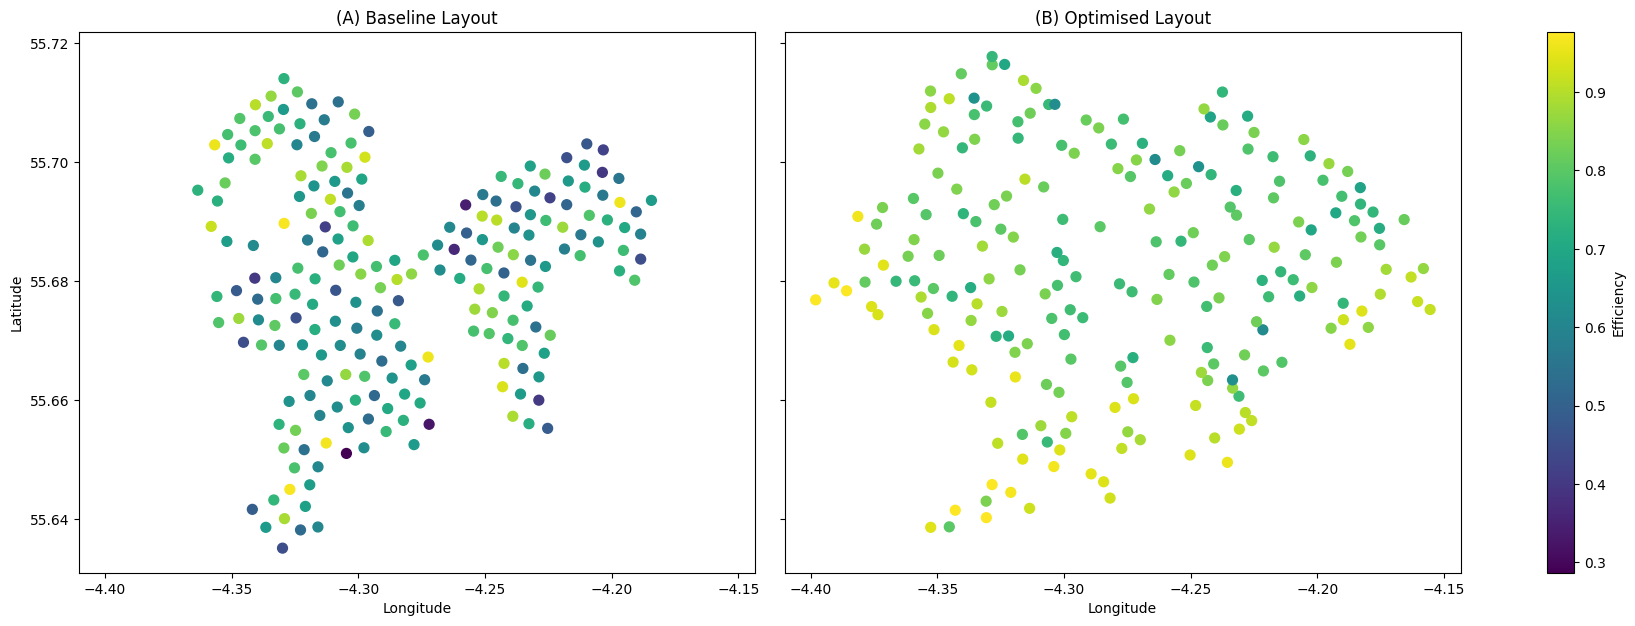

In [ ]:
'''
Further directions for this graph:
1. Let people know this is a map. Add the base map with the site border (can use PS).
2. X and Y scales be put inside the plot with logitude and latitude. Think of adding grids.
3. The projection can be UTM, while the scales are still corresponding longitude and latitude.
4. Add grey border to dots.
'''

# Visualisation

# Assuming turbine_loc, turbine_eff, optimised_loc, and optimised_eff are already defined
# turbine_loc and optimised_loc should be lists of (x, y) tuples
# turbine_eff and optimised_eff should be lists of efficiency values

# Extract x and y coordinates for baseline and optimized layouts
baseline_y, baseline_x = zip(*turbine_loc)
optimised_y, optimised_x = zip(*optimised_loc)

# Determine the global efficiency range for consistent colormap scaling
eff_min = min(min(turbine_eff), min(optimised_eff))
eff_max = max(max(turbine_eff), max(optimised_eff))

# Create the scatterplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True, sharex=True)
plt.tight_layout()  # This line should be put at the front to make everything right

# Baseline layout scatterplot
scatter1 = axes[0].scatter(baseline_x, baseline_y, c=turbine_eff, cmap='viridis', s=50, vmin=eff_min, vmax=eff_max)
axes[0].set_title('(A) Baseline Layout')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].set_xlim(bounds[0] - 0.01, bounds[2] + 0.01)
# axes[0].set_
# fig.colorbar(scatter1, ax=axes[0], label='Efficiency')  # This is commented out because it is the same as the second plot.

# Optimized layout scatterplot
scatter2 = axes[1].scatter(optimised_x, optimised_y, c=optimised_eff, cmap='viridis', s=50, vmin=eff_min, vmax=eff_max)
axes[1].set_title('(B) Optimised Layout')
axes[1].set_xlabel('Longitude')
fig.colorbar(scatter2, ax=axes.tolist(), label='Efficiency')

# Adjust layout and display the plots
plt.show()


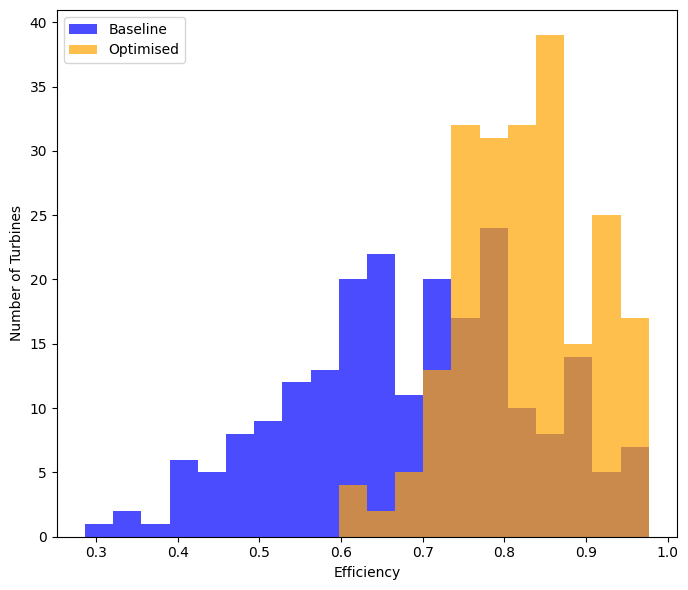

In [14]:
# Assuming turbine_loc, turbine_eff, optimised_loc, and optimised_eff are already defined
# turbine_loc and optimised_loc should be lists of (x, y) tuples
# turbine_eff and optimised_eff should be lists of efficiency values

# Extract x and y coordinates for baseline and optimized layouts
baseline_y, baseline_x = zip(*turbine_loc)
optimised_y, optimised_x = zip(*optimised_loc)

# Determine the global efficiency range for consistent colormap scaling
eff_min = min(min(turbine_eff), min(optimised_eff))
eff_max = max(max(turbine_eff), max(optimised_eff))

# Create the histogram
fig = plt.figure(figsize=(7, 6))

# Histogram for efficiency distribution
plt.hist(turbine_eff, bins=20, range=(eff_min, eff_max), alpha=0.7, label='Baseline', color='blue')
plt.hist(optimised_eff, bins=20, range=(eff_min, eff_max), alpha=0.7, label='Optimised', color='orange')
# plt.title('Efficiency distribution')
plt.xlabel('Efficiency')
plt.ylabel('Number of Turbines')
plt.legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# 4. Random Baseline

We try to randomly generate some layouts and check the performance.

In [15]:
%%script true
rng = np.random.default_rng(0)  # set the random seed to 0

layout_num = 1000 # number of random layouts
random_eff = np.zeros((layout_num,), dtype='float64')

# generate random locations
for i in range(layout_num):
    if i % 100 == 0:
        print(i)
    random_ind = rng.choice(gene_space, size=len(turbine_ind), replace=False)
    random_eff[i] = evaluate(len(random_ind), random_ind, True).mean()
random_eff = random_eff.tolist()

In [16]:
# %%script true
random_eff = [0.7095336502691507, 0.7074711686519206, 0.6882411633452548, 0.7005317441212958, 0.7057422084619791, 0.7083949749426525, 0.6983352580632989, 0.695548959517946, 0.7159053607627579, 0.707618506573647, 0.7109177914828871, 0.6914621870898993, 0.6913356408428418, 0.7099375821223141, 0.7000114906547371, 0.7114078036448845, 0.7103630882864232, 0.7103721505690471, 0.6839924444982993, 0.7139342667641664, 0.7065536300967302, 0.7062979203340813, 0.6998163857409407, 0.6968100692646007, 0.6933755217544101, 0.6933643381462349, 0.7019138684206699, 0.6911841830183885, 0.6934857976957467, 0.7022445121443708, 0.6900211021587493, 0.6986725237746991, 0.6861931341369607, 0.6881204505689631, 0.6844805352312104, 0.7002674207522027, 0.7112983523292737, 0.70669627462988, 0.7161833360342841, 0.7039826157581863, 0.6915514442386359, 0.7098047275629089, 0.6913879439907942, 0.721244101231446, 0.7068410206096232, 0.6964482647454302, 0.7082439286636343, 0.7049998624789395, 0.6768024001025437, 0.687468354022376, 0.7048955663562027, 0.7205047906025759, 0.7119394592142593, 0.7085340129575266, 0.6828408746127115, 0.7075163204419098, 0.7004665885428465, 0.6820089398190959, 0.7029717068679604, 0.7035941129891914, 0.7100532637998299, 0.6971219397039915, 0.7097132868179531, 0.7000947515568464, 0.7075196348890974, 0.7013517678106739, 0.7016846739614893, 0.6934080401528239, 0.7035241416995078, 0.6972332796905912, 0.7110832098181852, 0.6931483507055095, 0.7093229345752132, 0.7020675002641648, 0.6907343839151233, 0.7082478357441425, 0.6872979703437829, 0.6995604654680249, 0.692901154426642, 0.695042463833434, 0.7084689796371354, 0.7020039072655515, 0.7168562290394744, 0.7085166363189686, 0.696889640821928, 0.699212854844256, 0.6890094187370623, 0.702304685621562, 0.7070053968720907, 0.7111155794294058, 0.7228457839832224, 0.7026542052083744, 0.7005547944027563, 0.6939675551163217, 0.702408728036132, 0.703892768857304, 0.697888785744776, 0.7178628418787856, 0.6970455759241998, 0.7122469271513733, 0.6951414988176687, 0.7047676866025028, 0.6877796280054436, 0.714634497201571, 0.6927038621178202, 0.7051666904853986, 0.7068914029264877, 0.6923200026328112, 0.7053673689270816, 0.7240021060041162, 0.7114146421234289, 0.703058854593995, 0.6964176600138512, 0.7001552921597236, 0.6910662536987565, 0.6934956173716756, 0.7040662969783908, 0.687776730274924, 0.7132801255258255, 0.6925723040246922, 0.6998674109141173, 0.6966781704590274, 0.691647883742902, 0.7075000857705082, 0.7183074173119517, 0.6957973478834407, 0.6969425128294982, 0.7026488559579807, 0.6955372005865218, 0.6786135269131708, 0.7166858980696189, 0.7118331647275776, 0.7079283425139432, 0.7010551028395178, 0.7019952982070311, 0.7102339990452547, 0.7133211776604287, 0.6908465978068037, 0.7164350829206042, 0.7100186624706476, 0.7011040608011507, 0.7233950300497584, 0.7084877976045919, 0.683178359472007, 0.7027869146024183, 0.709882950730326, 0.697912359022636, 0.6986059167624048, 0.710177888075714, 0.7090305413436675, 0.7030464835758407, 0.7080790100156935, 0.697738613078585, 0.7032472209528737, 0.6946607357655694, 0.7190483130424148, 0.69362805161791, 0.6720138327315067, 0.7012592364242631, 0.6913360022907281, 0.681844430581488, 0.6865523260037895, 0.6885031326160526, 0.696861145772788, 0.7052928355781887, 0.7017216036989178, 0.7164734963250293, 0.6970685292521795, 0.6932415212933565, 0.6770935485412877, 0.7096634331978989, 0.6894044958813776, 0.7208705046011393, 0.6917539517658148, 0.7063253447932393, 0.7091277901897615, 0.6976808767722874, 0.6998213386996538, 0.6926117095461444, 0.6883325579488655, 0.7128441117561753, 0.7081670658785432, 0.6944077174382517, 0.6995038230280741, 0.7033548256023976, 0.6973093530748489, 0.698770215134822, 0.7132812010436484, 0.7109479758589339, 0.7008240688030418, 0.7047612290562341, 0.7064770074879041, 0.6925358813473577, 0.6976517607227705, 0.6962895689685741, 0.6972327484140536, 0.697639377094977, 0.6910742352842045, 0.7093966150764723, 0.6922575762398793, 0.6997909152329158, 0.6923135636286157, 0.6951713659280242, 0.6929792411072928, 0.7174895770622529, 0.6977616766537884, 0.7078532654982767, 0.6885088650770725, 0.7034791894933325, 0.7057239071173708, 0.692957453210352, 0.7138697241255986, 0.6904803397887492, 0.695386892899065, 0.7137445848152458, 0.6948169858171881, 0.7004234488494143, 0.7052319538962926, 0.7033477704214949, 0.7030858319752906, 0.7052055668886525, 0.6763551934984643, 0.6951498535163084, 0.7154954793066368, 0.7171938043724246, 0.7067122656332792, 0.6875380747322498, 0.7067115841381982, 0.688884237822373, 0.709519752852076, 0.7073446759762583, 0.6816558096716997, 0.7054818987411517, 0.7091943514468937, 0.6955681318927965, 0.7108556502770614, 0.6987680319858359, 0.7063061558445813, 0.6889229654102575, 0.7008387076774567, 0.6887811784833415, 0.6990021275921379, 0.699090469434767, 0.6899827621529976, 0.680324243716942, 0.6786436034038411, 0.6874969448452156, 0.7061544506077976, 0.705561156378966, 0.7033406498559516, 0.6936483054753209, 0.7004968234999497, 0.7109758295843595, 0.7045687949693586, 0.7064816250034536, 0.711557246480286, 0.7079471659541056, 0.7001777029876838, 0.6934713177507602, 0.710380046981924, 0.7141410409390132, 0.6917049942988899, 0.7176733997241846, 0.6991785782187097, 0.6877961474918689, 0.6883577416924632, 0.6839689516867213, 0.6986048159979829, 0.7021024013816273, 0.7199405422762196, 0.6992857245839951, 0.6800434424106578, 0.6935279548319722, 0.7084896380657129, 0.6973935599166013, 0.7125049333485307, 0.726141428993544, 0.6966168607374605, 0.7016723238668149, 0.7072722573426747, 0.7150445592658743, 0.6968075829846946, 0.7046970976108419, 0.6974285020073797, 0.7062885895753956, 0.7001210990771528, 0.6882427427325779, 0.6996185871811069, 0.7077886546289, 0.6877704280736074, 0.7176632777311056, 0.7062664370561292, 0.6838084132228971, 0.6877335637382356, 0.6975664558824012, 0.702623313028882, 0.6969200713714212, 0.7063990126369657, 0.7027431776368871, 0.7014992664223237, 0.6967310928098314, 0.6984734226041655, 0.6962034205043942, 0.6905538503184162, 0.6853273323914988, 0.7152033243917242, 0.6958348754079963, 0.7090739727892226, 0.7024909199010922, 0.7001330350386618, 0.6970548311220698, 0.7015120550261081, 0.7048478441099474, 0.7077900561794898, 0.7051798925416418, 0.7057739248410688, 0.686838937474951, 0.6917444869579666, 0.70812573245492, 0.6917877264282746, 0.6857181180255434, 0.7025277437714247, 0.69909756431554, 0.702656304535446, 0.7063701420192977, 0.704602893293439, 0.6966023466420365, 0.7089669187968882, 0.7054723348340889, 0.7074615168532452, 0.6862625350263734, 0.7054927833267045, 0.7127896414458512, 0.7068601382637979, 0.6947563217480742, 0.7014389299775554, 0.6989372371955288, 0.7105570629034673, 0.6898651186436258, 0.6915796812550863, 0.6859742964715579, 0.7013459253060287, 0.7012547455876312, 0.70786739836615, 0.7079706315533454, 0.6982913178511908, 0.7048312151292201, 0.6957088856804341, 0.7148151792531349, 0.7029521700364816, 0.7172107055601724, 0.700740970317536, 0.6882689417682202, 0.7015828610466822, 0.7028662745060675, 0.7133086994064871, 0.6966073576129744, 0.6922057832036984, 0.6894222128632718, 0.7054875870566791, 0.7023047552445619, 0.695839396729886, 0.7047819942484503, 0.7105581777387908, 0.7158557284868826, 0.6748832937926927, 0.6951488392618776, 0.6904525202765305, 0.6975550814034063, 0.707419766346283, 0.7247519660562105, 0.7273020951127409, 0.695126795659004, 0.6940351376826877, 0.7016151338209268, 0.6943734606620755, 0.7077492614095374, 0.705592382851367, 0.711880950390794, 0.6934430468646237, 0.7001086723557803, 0.6887790662385301, 0.6948768955848749, 0.7146804469392504, 0.7184427347199844, 0.6935450991255586, 0.7197778562959563, 0.7035640133998394, 0.6995433537692224, 0.7009901568575323, 0.6992951828988963, 0.6867112958969167, 0.6894235697022956, 0.7033520728381735, 0.7126548599329287, 0.6976864945150499, 0.7081944667477792, 0.7083086784703919, 0.7083464305273047, 0.6921937614282306, 0.7004524573360476, 0.700294314829164, 0.7032227896037123, 0.7024282352645309, 0.7155200950097186, 0.6960920270256363, 0.69695753422003, 0.6772037286683528, 0.695968901231396, 0.7046398184117563, 0.7078969290257355, 0.7054017126858521, 0.6929609164266296, 0.6815723447183721, 0.7004491229215586, 0.6956849061601135, 0.7091042868037741, 0.7013643883559513, 0.6851107816182193, 0.6904109248925189, 0.697178438177069, 0.7111006607071568, 0.705045809440489, 0.7013471913066647, 0.7088249164612326, 0.6949099155632008, 0.6927071663770523, 0.6984442832474715, 0.7041870527786204, 0.6850683358177825, 0.6939076184918672, 0.6850496343363169, 0.6945885459206448, 0.7093536932624541, 0.6965412904301068, 0.6999945614076954, 0.705571269460449, 0.7095100898818087, 0.6937506230446426, 0.7004630245445796, 0.707342403559306, 0.7100438584362266, 0.6788555052096769, 0.7147225744344687, 0.7096999861146064, 0.707711034076376, 0.6981966465486089, 0.7145519863753468, 0.6997405294492357, 0.7077472398796243, 0.7058940102919897, 0.6897180541424197, 0.7083508387776382, 0.6963320885045272, 0.684070228946431, 0.7140304721356581, 0.6967589886333337, 0.7086558401912525, 0.6988092991597508, 0.6978219409607677, 0.69111594884014, 0.7066762960732048, 0.7158314323697047, 0.6997649204926863, 0.6980355577156161, 0.7027847073120034, 0.7037283487051335, 0.6808523479367766, 0.7048149034002592, 0.7056971733831455, 0.7049199961843023, 0.7057573552812485, 0.7066888994447794, 0.7015288296979649, 0.7162840582143, 0.6968451127280502, 0.7029157272970098, 0.7020799022099142, 0.7009951381841167, 0.6947862635469603, 0.706124849511641, 0.7021976760306758, 0.7084863653733892, 0.7176191011785577, 0.7027530283942653, 0.7065023827148429, 0.7031880387281474, 0.6994296497205876, 0.6990213706886834, 0.7049453862621791, 0.6976669830713216, 0.7053218179906775, 0.7293455176656631, 0.706744637004865, 0.705833116646598, 0.6949939720337284, 0.7030732949858529, 0.7014381496327694, 0.6961067889188336, 0.6962049903995219, 0.7041172017329146, 0.7150758090671341, 0.7035288853458503, 0.6959352377301404, 0.6986996737671308, 0.7081932864075012, 0.7039661068384304, 0.703368045205626, 0.686685481708381, 0.6987762327941921, 0.6983907623516539, 0.712482807651869, 0.7146959921986155, 0.7016473294468366, 0.7055617153283237, 0.6920366198188929, 0.6940676434256652, 0.705856298940548, 0.6986886311865775, 0.7044501079368266, 0.7124454852324966, 0.6914687859407548, 0.6993123558136584, 0.7023436881357508, 0.6863437936957482, 0.6897102914004042, 0.7001705526671307, 0.6987992658742533, 0.7036001773230031, 0.7016648700710076, 0.7110885987655379, 0.7161578597160089, 0.7036887845396045, 0.7153024543923678, 0.6919556463464732, 0.704555780374888, 0.6844679803273822, 0.7176739714636409, 0.6794337541037225, 0.7093179268034794, 0.7069156356161472, 0.7082733127623947, 0.7049942950987974, 0.6927051830060563, 0.6956749623298905, 0.6871899265172114, 0.7161055057620016, 0.7076301864077774, 0.7135156674063703, 0.7044365093610723, 0.6978346053633684, 0.7036577795754998, 0.6816539539842438, 0.7021968429444788, 0.7267816834676408, 0.6963577407849115, 0.6918676498441431, 0.7137762522610819, 0.7097724173082748, 0.7042441464797781, 0.6852152206510265, 0.6950028219334121, 0.6936821904801548, 0.7079293004073551, 0.7119640423593248, 0.6857668135369411, 0.7048005977899667, 0.7010608352742943, 0.709747156512727, 0.7074295185297466, 0.7023808190835432, 0.7137950265954797, 0.7035556951538979, 0.7060114390539509, 0.7001096263568308, 0.6866352074064805, 0.692773814560189, 0.6958685882387893, 0.7080291922914801, 0.7105026204247809, 0.6850546108427913, 0.700948373324903, 0.6882778843018524, 0.7015703339800481, 0.7058810540538617, 0.7112091040482584, 0.6954784349076185, 0.6991975953298764, 0.7019554054386848, 0.6965748314531841, 0.7227395930504575, 0.7000438213627572, 0.6903184184242497, 0.6939289191220845, 0.7045596961510479, 0.7034274254663694, 0.7249739268771035, 0.6898219655106589, 0.703605416001179, 0.706870276129354, 0.6951679075639209, 0.7039603691952535, 0.7089586768663841, 0.6999982798170556, 0.7041455757275306, 0.704365990209008, 0.7143728701307813, 0.6993101792101322, 0.6769728041408887, 0.7086869493703063, 0.6981872785320831, 0.692675307570979, 0.7075675509290316, 0.695298703633846, 0.7004462615033011, 0.7028053549383977, 0.7090713378141813, 0.6950087074695739, 0.7024738807889432, 0.7023396967629284, 0.6923877561124839, 0.6952877490149059, 0.7057785049205352, 0.6917117715953321, 0.6933921723925207, 0.7126958668135882, 0.7024256302917101, 0.717458153352858, 0.6892686809200014, 0.7094498791444838, 0.6961773749826743, 0.6955571025317614, 0.6868748159158269, 0.6947302206720396, 0.6941150812052144, 0.6957537045569628, 0.6925396175874452, 0.7098231655711391, 0.7077544847756617, 0.7106785628380392, 0.7173897735935292, 0.7075771910906887, 0.7033522567891557, 0.6994175138475086, 0.7089569507223923, 0.704272668636248, 0.6926378151449848, 0.6981594154788882, 0.693330581222755, 0.6989445925967507, 0.7016522409270425, 0.7113208712709358, 0.7177004252342576, 0.7224039452227843, 0.6952535153796309, 0.7031261637369468, 0.6953473201868184, 0.7048811570752588, 0.6948430690247178, 0.6967355187513027, 0.6990307301272097, 0.696235851512674, 0.6990510969860471, 0.7025231131025794, 0.6928100843435063, 0.7004264620921604, 0.6956505281285097, 0.6796600478170464, 0.6964104295787712, 0.7098684148988618, 0.7083888901830955, 0.6995758586237091, 0.7043355938148016, 0.6867525546586043, 0.7090579817872854, 0.6877113818625414, 0.7083525920541711, 0.714260321041849, 0.7158532159590997, 0.7094783845293947, 0.7121996900273699, 0.7067563921865329, 0.704828464865852, 0.7181218051977429, 0.6971002813069744, 0.7152657616013767, 0.6983783304362241, 0.708511826435473, 0.7024054667353021, 0.675321747310201, 0.7062470376789911, 0.6960522366728059, 0.6993353367237732, 0.6872375163213134, 0.7044823637880648, 0.7079697605153664, 0.7000232824074075, 0.6900989857324533, 0.7002349655693811, 0.6702776353242007, 0.706240923620673, 0.706932586670937, 0.6952397330596857, 0.6966528142477217, 0.7068256618046189, 0.6954775104299835, 0.6991036691603139, 0.7062156219405493, 0.71058558009755, 0.6953870884291369, 0.6954239114182063, 0.7056573613941495, 0.6887548919358497, 0.6989440223297002, 0.7050902440906917, 0.7100226827251704, 0.6913768057564564, 0.6973233028793391, 0.698357070870038, 0.7001565609363306, 0.6874540219179817, 0.7006857715854736, 0.7074136855489958, 0.7149191267918289, 0.6864330065288555, 0.707473420048822, 0.6930988841274536, 0.7072455906870906, 0.723973003474462, 0.7116073828540551, 0.7089693891830836, 0.7006106841963529, 0.691608584579818, 0.6914148538021097, 0.696109649106978, 0.7050983649346253, 0.6963874385337291, 0.7015525837772915, 0.7092181766806035, 0.6950752674642637, 0.7107744359683907, 0.7009916796447191, 0.7014204754162771, 0.7116430200060498, 0.7144712098807301, 0.6907199823536507, 0.6917432610005211, 0.7006578281457625, 0.7152382851911678, 0.6958054652886984, 0.6983986791539102, 0.6923207434827297, 0.7173688429365389, 0.7094402775719835, 0.6816278517269093, 0.6761620247719602, 0.6876582011742219, 0.7011417108224353, 0.6994048144621621, 0.7168056464987957, 0.6995403135409517, 0.7006866203057703, 0.6975293661536065, 0.7236172721869437, 0.7016889693513917, 0.707340812812433, 0.6884961689301783, 0.6925251221056529, 0.6937144930731948, 0.6922645980110503, 0.6991598560021501, 0.7092728718340486, 0.7118425098869572, 0.6943274056192935, 0.7083707352232494, 0.7049219303511616, 0.7024071593935811, 0.6903059433744643, 0.7035158561070035, 0.7109060707250695, 0.7066526939565537, 0.67981263282351, 0.7047510395072042, 0.7019900581478451, 0.696116841585142, 0.7054058650812458, 0.6936175051122188, 0.6931627860447402, 0.7007679666458184, 0.704998184504704, 0.7046096206067641, 0.698249677322442, 0.6918711698628126, 0.7073724745981463, 0.7105578289544134, 0.6920505994147033, 0.6967655319322653, 0.6861164059164094, 0.6862413766924694, 0.6811864561246905, 0.7157545076601103, 0.6737455333233073, 0.6991354796996024, 0.6963833183931019, 0.7078220428567181, 0.7132202210569738, 0.6975342841589877, 0.7027191904590123, 0.7019520654223448, 0.7121773202109721, 0.6937523741667588, 0.7060239986095617, 0.7028548754594383, 0.7077500897780851, 0.7052428550308849, 0.7082915181833285, 0.716293509868095, 0.698098269404721, 0.7024794679953378, 0.6983033866537778, 0.6926804493450974, 0.7036447247453846, 0.6954806395478422, 0.7018995418415626, 0.699133992409576, 0.7036229426436006, 0.7050058514596222, 0.6956054136132145, 0.7100135898181145, 0.698713489908024, 0.7140582253015222, 0.6841966575477231, 0.6784664233510264, 0.7038852106037486, 0.682244245161749, 0.7093740839779378, 0.702552802966211, 0.6880770353440877, 0.7014531645000888, 0.7032547595301054, 0.7062860678607052, 0.7103520678075343, 0.6892301752776372, 0.7062899442933855, 0.7154658954683079, 0.687638166592452, 0.6870067409144642, 0.7017172858189892, 0.7136000397420704, 0.6861971126201439, 0.6862734375882206, 0.7082260001948611, 0.6901634082255798, 0.6943820939909117, 0.720851168487396, 0.7041652505486302, 0.6896186954546553, 0.6912544727564386, 0.7037777881584698, 0.6971014574242603, 0.6926417191090803, 0.7048998437496639, 0.6910628320815804, 0.7047391446216381, 0.712316772944916, 0.7136510954568742, 0.7019354799912275, 0.7057611974058895, 0.6933951652240206, 0.7172422851924263, 0.6877479330919872, 0.6928100302197174, 0.7027504213698011, 0.7101787980441437, 0.6867788815405895, 0.7070465018563287, 0.6948744509123694, 0.6896312208267114, 0.7052873809655315, 0.7145105365018446, 0.6935652525546462, 0.7036150821542788, 0.7033108527291344, 0.703144057870058, 0.7050969791667729, 0.6873881377562712, 0.7121852205863394, 0.6925121839359264, 0.6985695586349548, 0.700315179015255, 0.6750769304807616, 0.7047713501963273, 0.7020334395102558, 0.7134185184151913, 0.697639698497252, 0.6940896799760975, 0.696295350215276, 0.7011136145146335, 0.7041292537468659, 0.6903742498075549, 0.6939981581561475, 0.7003410139508583, 0.7129456613415989, 0.7062524855632125, 0.7072516906796736, 0.7105107909826621, 0.7102078428533642, 0.7069244445952831, 0.714394443604224, 0.7182417485619567, 0.7054798784086682, 0.697128258820529, 0.6955278992756148, 0.7115903787183689, 0.6987519051905848, 0.6989584366934589, 0.7111735611519561, 0.6953811962334515, 0.7013084791297514, 0.7030637684876428, 0.6992258781583324, 0.7167680067584633, 0.7126853222381898, 0.7144210520770284, 0.6913942678071707, 0.7079364131986757, 0.7035105844072929, 0.6949468356265684, 0.6934204280373237, 0.701867812306793, 0.6906975798356143, 0.7006517234401525, 0.7067598222382476, 0.7120468211694173, 0.6901500483357714, 0.7191326825565773, 0.7062333553952369, 0.701539416124133, 0.7191047543599164, 0.6954837404218662, 0.6894429730484612, 0.6990293400773154, 0.6995965027497945, 0.7011499257516012, 0.705922173648905, 0.6925650307450559, 0.7036762862477111, 0.6980515604471166, 0.7059807097443977, 0.688247592527688, 0.6936032334472604, 0.6821158248743475, 0.7004755758894619, 0.70280912565568, 0.6997700314333865, 0.696847665230109, 0.6986640145908076, 0.7100319130166582, 0.6902011578336519, 0.7023012158473042, 0.7079848975655816, 0.6869816659041142, 0.7057502305183374, 0.703713977847026, 0.6844319187095713, 0.6842966321498438, 0.6909296575472518, 0.701545475643276, 0.6780738711871859, 0.7017261207991016, 0.701262793811391, 0.6985042612370317, 0.7051874708896047, 0.7018527396006405, 0.7114317604042801, 0.7092409812892737, 0.7068114891375835, 0.6974215726204114, 0.6994785321101284, 0.6934955251335713, 0.7097309883308589, 0.7177195380154869, 0.6967459535001452, 0.7144323819766257, 0.7067329278361592, 0.696397265538073, 0.7059730577157383, 0.6950106689971725, 0.706809533222578, 0.6897285236838567, 0.6945662432067381, 0.7070739827962603, 0.7079750417671505, 0.7038498003230431, 0.7040690709284709, 0.7074535053061943, 0.7080820973922584, 0.7050306073712218, 0.7167150084302264, 0.6934012695792157]

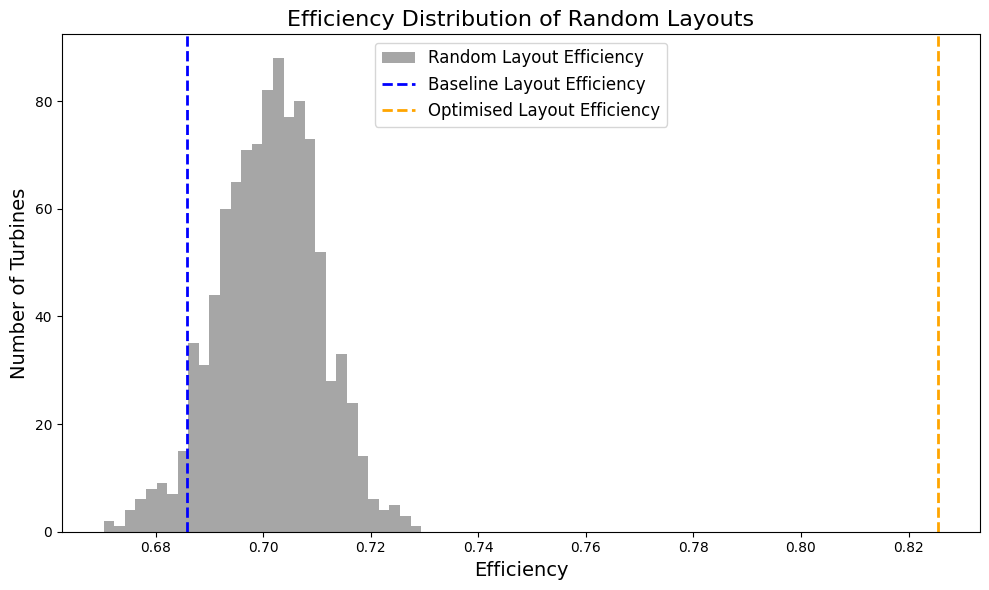

In [17]:
# Create a histogram of random_eff with vertical lines for turbine_eff and optimised_eff
fig, ax = plt.subplots(figsize=(10, 6))

# Plot histogram for random_eff
ax.hist(random_eff, bins=30, alpha=0.7, label='Random Layout Efficiency', color='gray')

# Add vertical lines for turbine_eff and optimised_eff
ax.axvline(np.mean(turbine_eff), color='blue', linestyle='--', linewidth=2, label='Baseline Layout Efficiency')
ax.axvline(np.mean(optimised_eff), color='orange', linestyle='--', linewidth=2, label='Optimised Layout Efficiency')

# Add labels, title, and legend
ax.set_title('Efficiency Distribution of Random Layouts', fontsize=16)
ax.set_xlabel('Efficiency', fontsize=14)
ax.set_ylabel('Number of Turbines', fontsize=14)
ax.legend(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

In [18]:
# Check how many random layouts are better than the baseline
count = 0
temp = turbine_eff.mean()
print(f"Baseline Efficiency: {temp:.2f}")
print(f'random_eff mean: {np.mean(random_eff):.2%}')
for i in range(len(random_eff)):
    if random_eff[i] > temp:
        count += 1
print(f"Proportion of random layouts worse than baseline: {1 - count / len(random_eff):.2%}")

Baseline Efficiency: 0.69
random_eff mean: 70.11%
Proportion of random layouts worse than baseline: 5.10%
